# Tarea de Estimación

Estimar valores de S(wo), S(3wo), S(5wo)

$\hat{s} = {S(w_i) \in R }$

$s \in R^3$

Señal de entrada:
$ x(t) = Cos w_o t - \tfrac{1}{3}Sin3w_o t + \tfrac{1}{5}Cos5w_o t$

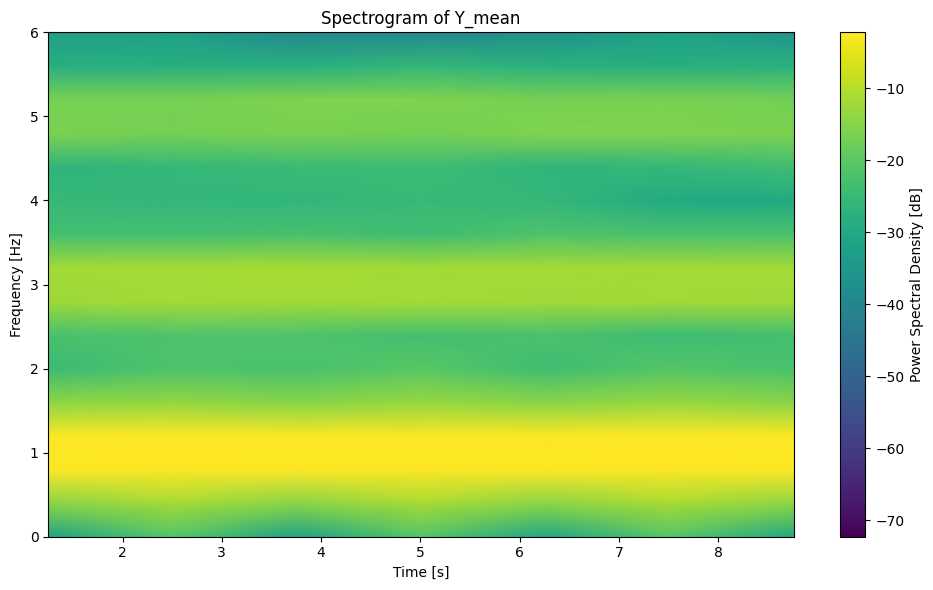

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import spectrogram, welch

def randomatrix (N, M, media, varianza):
    return np.random.normal(media, np.sqrt(varianza), (N, M))

def real_signal (wo,t):
    return np.cos(wo*t) - (1/3)*np.sin(3*wo*t) + (1/5)*np.cos(5*wo*t)

N = 1024
M = 512
media = 0
varianza = 3
wo = 2*np.pi

gaussmatrix = randomatrix(N,M,media,varianza)

t = np.linspace(0, 10, N)

Y = np.zeros((M, N))
for i in range(M):
    Y_true = real_signal(wo, t)
    Y[i] = Y_true + gaussmatrix[:,i]


Y_mean = np.mean(Y, axis=0)

frequencies, times, Sxx = spectrogram(Y_mean, fs=1/(t[1] - t[0]), nperseg=256, noverlap=128)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.title('Spectrogram of Y_mean')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Power Spectral Density [dB]')
plt.ylim([0, 6])  # Adjust ylim based on your frequency range of interest
plt.tight_layout()
plt.show()

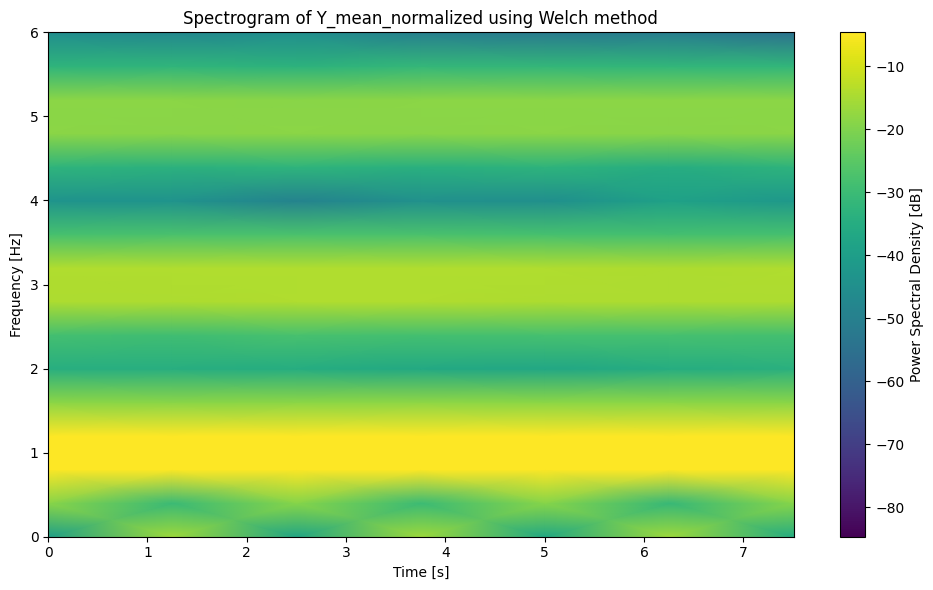

In [ ]:
# Normalizar Y_mean al rango [-1, 1]
Y_mean_normalized = 2 * (Y_mean - np.min(Y_mean)) / (np.max(Y_mean) - np.min(Y_mean)) - 1

# Parámetros para Welch
nperseg = 256
noverlap = 128
fs = 1 / (t[1] - t[0])

# Número de segmentos
n_segments = (N - nperseg) // (nperseg - noverlap) + 1

# Inicializar arrays para almacenar resultados
frequencies = np.fft.fftfreq(nperseg, d=1/fs)[:nperseg//2]
times = np.arange(n_segments) * (nperseg - noverlap) / fs
Sxx = np.zeros((len(frequencies), n_segments))

# Calcular PSD usando Welch para cada segmento
for i in range(n_segments):
    start = i * (nperseg - noverlap)
    end = start + nperseg
    segment = Y_mean_normalized[start:end]
    f, Pxx = welch(segment, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nperseg)
    Sxx[:, i] = Pxx[:nperseg//2]

# Plotear el espectrograma
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.title('Spectrogram of Y_mean_normalized using Welch method')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Power Spectral Density [dB]')
plt.ylim([0, 6])  # Ajustar según el rango de frecuencias de interés
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Estimar el espectro de potencia usando el método de Welch
def estimate_power_spectrum(signal, fs=1.0):
    f, Pxx = welch(signal, fs=fs, nperseg=256)
    return f, Pxx

# Obtener las componentes espectrales verdaderas
def true_spectrum_components(wo):
    return [1.0, 1/3, 1/5]

# Crear conjunto de datos
X = []
y = []
for i in range(M):
    f, Pxx = estimate_power_spectrum(Y[i], fs=N/10)
    X.append(Pxx)
    y.append(true_spectrum_components(wo))

X = np.array(X)
y = np.array(y)

# Normalizar datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Crear y entrenar la red neuronal
model = Sequential()

## Ejercicios:

Y es una matriz (N,M) N = 64 M = 32 y N = 1028 M = 256

1. Entrenar N.N. con entrada de Y y salida de vector de welch. Hallar mean_square_error

2. Entrenar N.N. con entrada de Y y salida de vector $R^3, [S(wo),S(3wo),S(5wo)]$

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import spectrogram, welch

def randomatrix (N, M, media, varianza):
    return np.random.normal(media, np.sqrt(varianza), (N, M))

def real_signal (wo,t):
    return np.cos(wo*t) - (1/3)*np.sin(3*wo*t) + (1/5)*np.cos(5*wo*t)

N = 1024
M = 512
media = 0
varianza = 0.3
wo = 2*np.pi

gaussmatrix = randomatrix(N,M,media,varianza)

t = np.linspace(0, 10, N)

Y = np.zeros((M, N))
for i in range(M):
    Y_true = real_signal(wo, t)
    Y[i] = Y_true + gaussmatrix[:,i]

In [9]:

#WELCH
nperseg = 256
noverlap = 128
fs = 1 / (t[1] - t[0])

psd_matrix = np.zeros((M, N//2))
"""for i in range(M):
    f, psd = welch(Y[i], fs=fs, nperseg=nperseg, noverlap=noverlap)
    psd_matrix.append(psd)
"""

'for i in range(M):\n    f, psd = welch(Y[i], fs=fs, nperseg=nperseg, noverlap=noverlap)\n    psd_matrix.append(psd)\n'

In [10]:
psd_matrix.shape

(512, 512)